In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.color import *
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

In [2]:
tf.test.is_built_with_cuda()  

True

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


In [4]:
dir_cvc = './CVC-ClinicDB/'
dir_etis = './ETIS-LaribPolypDB/'

images_cvc = sorted(glob(os.path.join(dir_cvc, "Original/*")))
masks_cvc = sorted(glob(os.path.join(dir_cvc, "Ground Truth/*")))
images_etis = sorted(glob(os.path.join(dir_etis, "ETIS-LaribPolypDB/*")))
masks_etis= sorted(glob(os.path.join(dir_etis, "Ground Truth/*")))

In [5]:
print('Total data from CVC ', len(images_cvc))
print('Total data from ETIS ', len(images_etis))

Total data from CVC  612
Total data from ETIS  196


In [6]:
images_total_path = [*images_cvc, *images_etis]
len(images_total_path)

808

In [7]:
masks_total_path = [*masks_cvc, *masks_etis]
len(images_total_path)

808

In [8]:
images_total_path[610:617]

['./CVC-ClinicDB/Original\\98.tif',
 './CVC-ClinicDB/Original\\99.tif',
 './ETIS-LaribPolypDB/ETIS-LaribPolypDB\\1.tif',
 './ETIS-LaribPolypDB/ETIS-LaribPolypDB\\10.tif',
 './ETIS-LaribPolypDB/ETIS-LaribPolypDB\\100.tif',
 './ETIS-LaribPolypDB/ETIS-LaribPolypDB\\101.tif',
 './ETIS-LaribPolypDB/ETIS-LaribPolypDB\\102.tif']

In [9]:
masks_total_path[610:617]

['./CVC-ClinicDB/Ground Truth\\98.tif',
 './CVC-ClinicDB/Ground Truth\\99.tif',
 './ETIS-LaribPolypDB/Ground Truth\\p1.tif',
 './ETIS-LaribPolypDB/Ground Truth\\p10.tif',
 './ETIS-LaribPolypDB/Ground Truth\\p100.tif',
 './ETIS-LaribPolypDB/Ground Truth\\p101.tif',
 './ETIS-LaribPolypDB/Ground Truth\\p102.tif']

In [10]:
def create_data_list(img_path, mask_path, split=0.1):
    total_size = len(img_path)
    split_number = int(split*total_size)
    
    train_x, valid_x = train_test_split(img_path, test_size=split_number, random_state=42)
    train_y, valid_y = train_test_split(mask_path, test_size=split_number, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=split_number, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_number, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [11]:
def read_image(image_path, image_size): # image_size = 256
    x = imread(image_path)
    x = resize(x, (image_size, image_size))
    x = x[:, :,0:3]
    return x

def read_mask(mask_path, image_size):
    x = imread(mask_path)
    x = resize(x, (image_size, image_size))
    x = np.expand_dims(x, axis=-1) #(256,256,1)
    return x

In [12]:
def prepare_data(image_paths_list, mask_paths_list, image_size=256):
    images = np.ndarray((len(image_paths_list), image_size, image_size, 3))
    labels = np.ndarray((len(image_paths_list), image_size, image_size, 1))
    for i in range(len(image_paths_list)):
        images[i]=read_image(image_paths_list[i], image_size=image_size)
        labels[i]=read_mask(mask_paths_list[i], image_size=image_size)
    return images, labels

In [13]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = create_data_list(images_total_path, masks_total_path)
print(len(train_x))
print(len(valid_x))
print(len(test_x))

648
80
80


In [14]:
(train_images, train_labels) = prepare_data(train_x, train_y)
print("Training Images Shape :", train_images.shape)
print("Training Labels Shape :", train_labels.shape)

Training Images Shape : (648, 256, 256, 3)
Training Labels Shape : (648, 256, 256, 1)


In [15]:
train_images[10]

array([[[0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725]],

       [[0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725]],

       [[0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725]],

       ...,

       [[0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0.04313725, 0.04313725],
        [0.04313725, 0

In [16]:
(valid_images, valid_labels) = prepare_data(valid_x, valid_y)
print("Valid Images Shape :", valid_images.shape)
print("Valid Labels Shape :", valid_labels.shape)

Valid Images Shape : (80, 256, 256, 3)
Valid Labels Shape : (80, 256, 256, 1)


In [17]:
(test_images, test_labels) = prepare_data(test_x, test_y)
print("Test Images Shape :", test_images.shape)
print("Test Labels Shape :", test_labels.shape)

Test Images Shape : (80, 256, 256, 3)
Test Labels Shape : (80, 256, 256, 1)


random index = 638


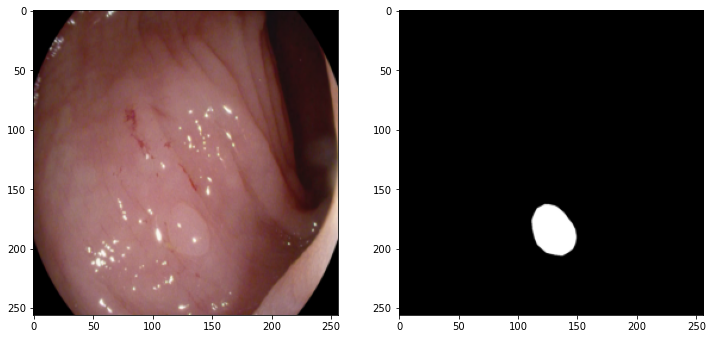

In [18]:
r = random.randint(0, len(train_images)-1)
print("random index =", r)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(train_images[r]);
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(train_labels[r], (256, 256)), cmap='gray') ;

## Convolutional Blocks

In [19]:
def down_block(x, filters, kernel_size=(3, 3), init='he_normal', padding='same', strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation='relu')(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation='relu')(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), init='he_normal', padding='same', strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation='relu')(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation='relu')(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), init='he_normal', padding='same', strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation='relu')(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_initializer=init, activation='relu')(c)
    c = keras.layers.Dropout(0.25)(c) #ditambahi drop out
    return c

## U-Net model

In [20]:
def create_unet(image_size=256, filters = [32, 64, 128, 256, 512]):
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) 
    c2, p2 = down_block(p1, filters[1])
    c3, p3 = down_block(p2, filters[2])
    c4, p4 = down_block(p3, filters[3])
    
    bn = bottleneck(p4, filters[4])
    
    u1 = up_block(bn, c4, filters[3])
    u2 = up_block(u1, c3, filters[2])
    u3 = up_block(u2, c2, filters[1])
    u4 = up_block(u3, c1, filters[0])
    
    outputs = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [21]:
model = create_unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Training the Model

In [22]:
epochs = 50
batch_size = 8
lr = 1e-3
x_axis_inc = 1

In [23]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

In [24]:
fig_train = 'result/polyp_detection_unet'
log_file = 'result/polyp_detection_unet.csv'
model_path = 'result/polyp_unet_01.h5'
sub_title = 'Polyp Detection using U-Net'

In [25]:
def plot_history(sejarah, fig, subtitle):
    epoch_list = list(range(1,epochs+1)) 
    y_train_acc = sejarah.history['accuracy']
    y_val_acc = sejarah.history['val_accuracy']
    y_train_loss = sejarah.history['loss']
    y_val_loss = sejarah.history['val_loss']
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(29,4))
    t = f.suptitle(subtitle, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    
    ax1.plot(epoch_list, y_train_acc, label='Train Accuracy')
    ax1.plot(epoch_list, y_val_acc, label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, x_axis_inc))
    ax1.set_ylim(0.4,1)
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, y_train_loss, label='Train Loss')
    ax2.plot(epoch_list, y_val_loss, label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, x_axis_inc))
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Cross Entropy')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    plt.savefig(fig_train)

In [26]:
callbacks = [CSVLogger(log_file), ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)]

In [27]:
history = model.fit(train_images, train_labels, validation_data=(valid_images, valid_labels), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/50
81/81 [==============================] - 22s 267ms/step - loss: 0.4185 - accuracy: 0.9089 - val_loss: 0.2258 - val_accuracy: 0.9195
Epoch 2/50
81/81 [==============================] - 21s 263ms/step - loss: 0.2340 - accuracy: 0.9176 - val_loss: 0.2378 - val_accuracy: 0.9195
Epoch 3/50
81/81 [==============================] - 21s 264ms/step - loss: 0.2255 - accuracy: 0.9176 - val_loss: 0.2347 - val_accuracy: 0.9195
Epoch 4/50
81/81 [==============================] - 21s 264ms/step - loss: 0.2253 - accuracy: 0.9176 - val_loss: 0.2421 - val_accuracy: 0.9195
Epoch 5/50
81/81 [==============================] - 21s 265ms/step - loss: 0.2166 - accuracy: 0.9176 - val_loss: 0.2194 - val_accuracy: 0.9195
Epoch 6/50
81/81 [==============================] - 22s 267ms/step - loss: 0.2122 - accuracy: 0.9177 - val_loss: 0.2311 - val_accuracy: 0.9197
Epoch 7/50
81/81 [==============================] - 22s 267ms/step - loss: 0.2059 - accuracy: 0.9194 - val_loss: 0.1976 - val_accuracy: 0.9259

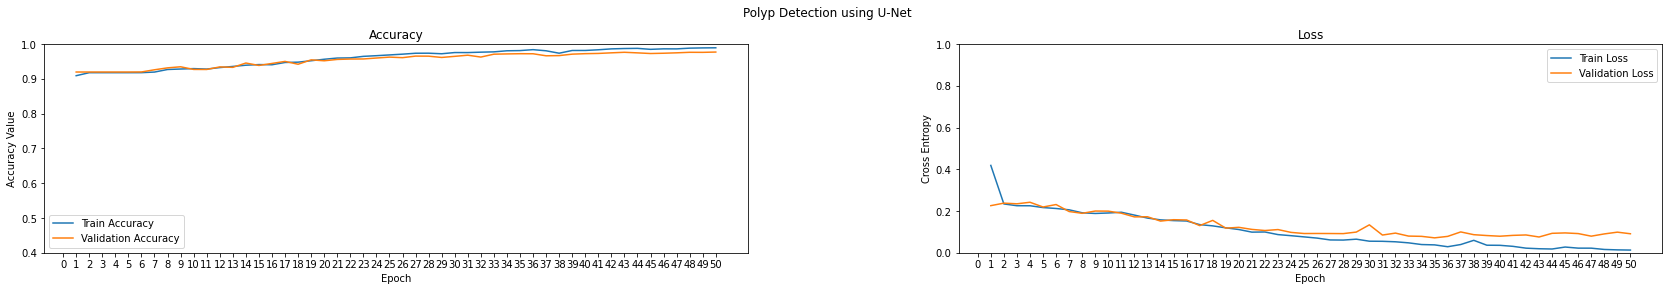

In [28]:
plot_history(history, fig_train, sub_title)

In [29]:
predicted_images = model.predict(test_images, batch_size=batch_size, verbose=1)
print("predicted Images shape ", predicted_images.shape)

10/10 [==============================] - 1s 73ms/step
predicted Images shape  (80, 256, 256, 1)


In [30]:
np.save('result/predicted_image.npy', predicted_images)

Text(0.5, 0, 'Prediction')

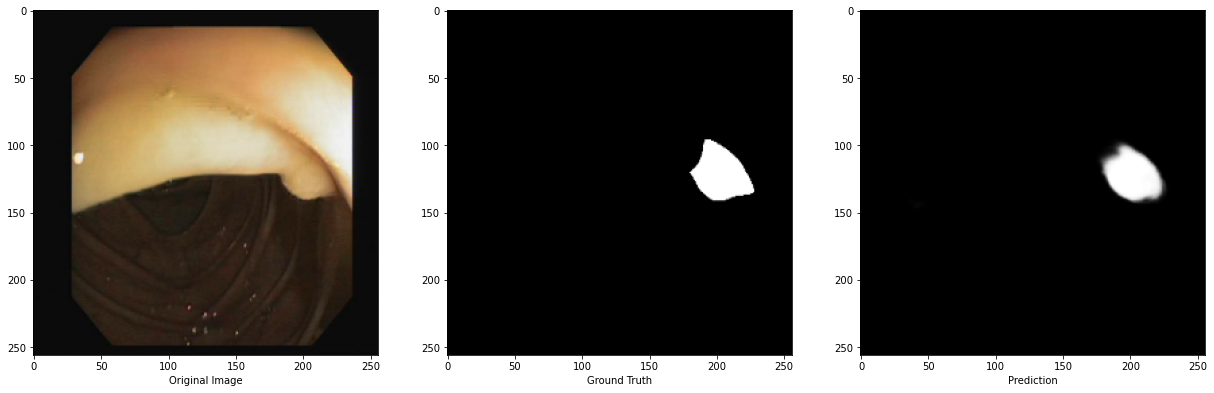

In [31]:
ind_test=2
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.imshow(test_images[ind_test]);
plt.xlabel('Original Image')
plt.subplot(1,3,2)
plt.imshow(test_labels[ind_test], cmap='gray');
plt.xlabel('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(predicted_images[ind_test], cmap='gray');
plt.xlabel('Prediction')

In [32]:
predicted_images[11][60:65,38:42]

array([[[4.0366308e-07],
        [6.6380795e-07],
        [1.1545786e-06],
        [1.8867325e-06]],

       [[3.8645734e-07],
        [6.0759487e-07],
        [1.0440792e-06],
        [1.7478304e-06]],

       [[3.6814632e-07],
        [5.7069713e-07],
        [9.9706392e-07],
        [1.6483926e-06]],

       [[3.3900838e-07],
        [5.3190098e-07],
        [9.6034876e-07],
        [1.6519226e-06]],

       [[3.0621450e-07],
        [4.9541575e-07],
        [9.3207927e-07],
        [1.6202652e-06]]], dtype=float32)

In [33]:
predicted_images_2=predicted_images.copy()

## Apply threshold to predicted images

In [34]:
predicted_images_2[predicted_images_2>=0.5]=1
predicted_images_2[predicted_images_2<0.5]=0

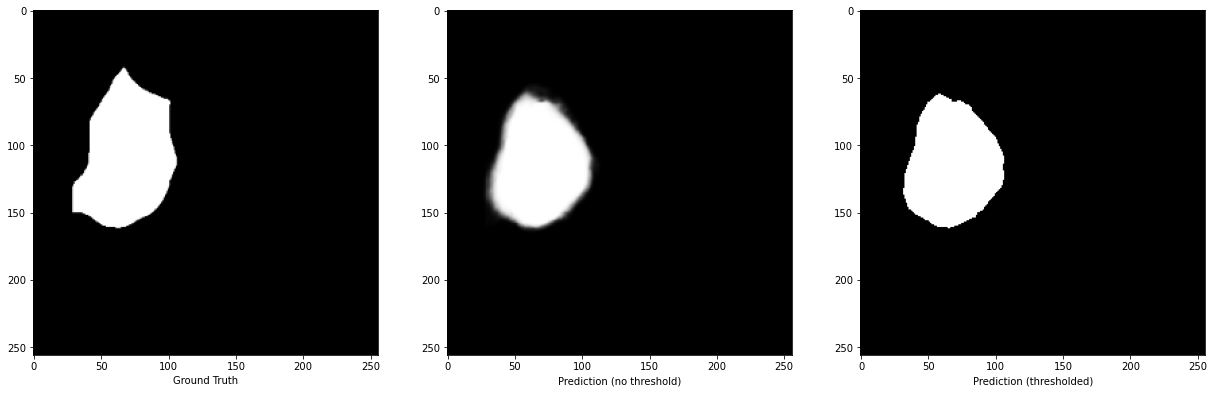

In [35]:
index=54
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.xlabel('Ground Truth')
plt.imshow(test_labels[index], cmap='gray');
plt.subplot(1,3,2)
plt.xlabel('Prediction (no threshold)')
plt.imshow((predicted_images[index]), cmap='gray');
plt.subplot(1,3,3)
plt.xlabel('Prediction (thresholded)')
plt.imshow(predicted_images_2[index], cmap='gray');

## Model evaluation

In [36]:
def visualize(index):
    plt.figure(figsize=(21,7))
    plt.subplot(1,3,1)
    plt.imshow(test_images[index]);
    plt.xlabel('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(predicted_images_2[index], cmap='gray');
    plt.xlabel('Prediction')

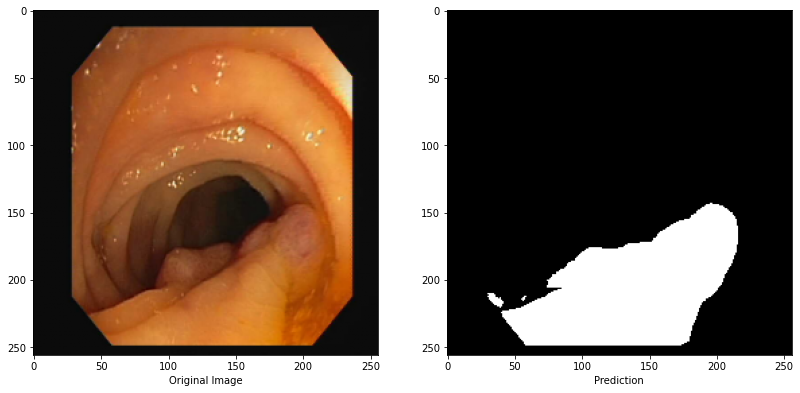

In [37]:
visualize(1)

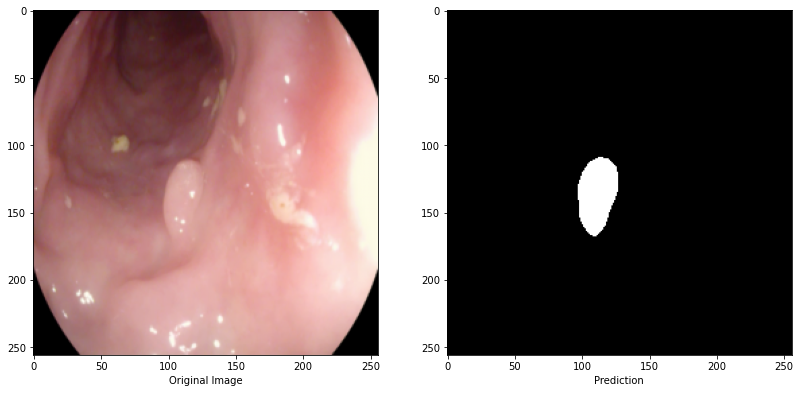

In [38]:
visualize(4)

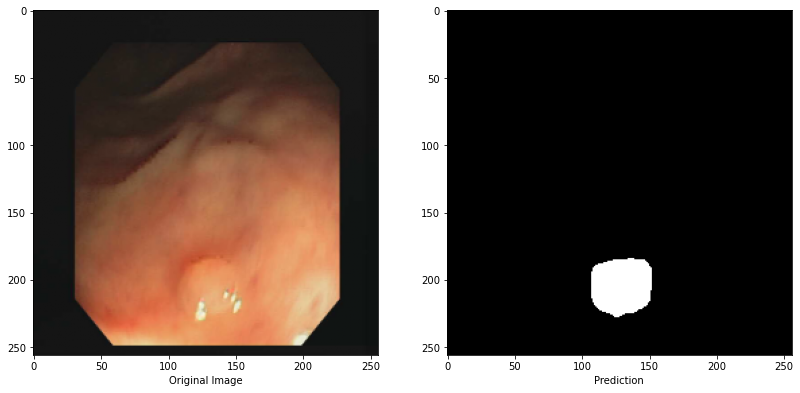

In [39]:
visualize(50)

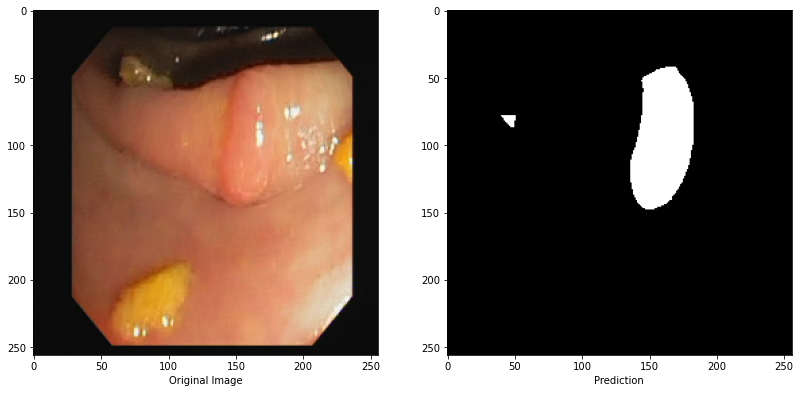

In [40]:
visualize(32)

In [41]:
intersection = np.logical_and(test_labels, predicted_images_2)
union = np.logical_or(test_labels, predicted_images_2)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU Score: %.3f  ' % (iou_score*100))

IoU Score: 74.919  


In [42]:
test_labels_flat = test_labels.flatten().astype(int)
predicted_images_flat = predicted_images_2.flatten().astype(int)

In [43]:
test_labels_flat.shape

(5242880,)

In [44]:
predicted_images_flat.shape

(5242880,)

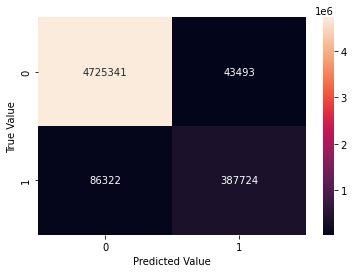

In [45]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
confusion_matrix = confusion_matrix(test_labels_flat, predicted_images_flat)
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.xlabel("Predicted Value");
plt.ylabel("True Value");

In [46]:
accuracy = accuracy_score(test_labels_flat, predicted_images_flat)
precision = precision_score(test_labels_flat, predicted_images_flat)
recall = recall_score(test_labels_flat, predicted_images_flat)
f1 =  f1_score(test_labels_flat, predicted_images_flat)
print('Accuracy: %.3f ' % (accuracy*100))
print('Precision: %.3f  ' % (precision*100))
print('Recall: %.3f  ' % (recall*100))
print('F1 Score: %.3f  ' % (f1*100))

Accuracy: 97.524 
Precision: 89.914  
Recall: 81.790  
F1 Score: 85.660  
